# Influence des infrastructures et aménagements routiers
# -> Peut t'on predire la severite d'un accident

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .master("local[*]")\
    .appName("Accident")\
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

your 131072x1 screen size is bogus. expect trouble
25/05/31 16:05:35 WARN Utils: Your hostname, DESKTOP-NHT3FJU resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/05/31 16:05:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/31 16:05:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.parquet("../../data/processed_accidents.parquet")
df.show(5, truncate=False)

+--------+-------------------+-------------------+---------+-----------+------------------+---------------+-----------+-----+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----------------------+----------------------+-------------------------+-----------------------------+-------------------------+----------------------+-------------+------------+----------------------+----------------------+-------------------------+-----------------------------+-------------------------+----------------------+---------------+--------------------+
|Severity|Start_Time         |End_Time           |Start_Lat|Start_Lng  |Distance(mi)      |City           |County     |State|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)

## Preprocess

On ne garde que les colonnes qui semblent importante pour la prediction de la severite d'un accident

In [3]:
columns_to_keep = [
    "Severity",

    'Start_Lat', 'Start_Lng', 'Distance(mi)',

    'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
    'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)',

    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
    'Traffic_Signal', 'Turning_Loop',

    'Sunrise_Sunset_encoded', 'Civil_Twilight_encoded',
    'Nautical_Twilight_encoded', 'Astronomical_Twilight_encoded',

    'Weather_Condition_encoded', 'Wind_Direction_encoded',
    'State_encoded'
]

df = df.select(columns_to_keep)

On plot la matrice de correlation avec toutes les colonnes selectionne juste avant pour s'assurer une bonne qualite des features

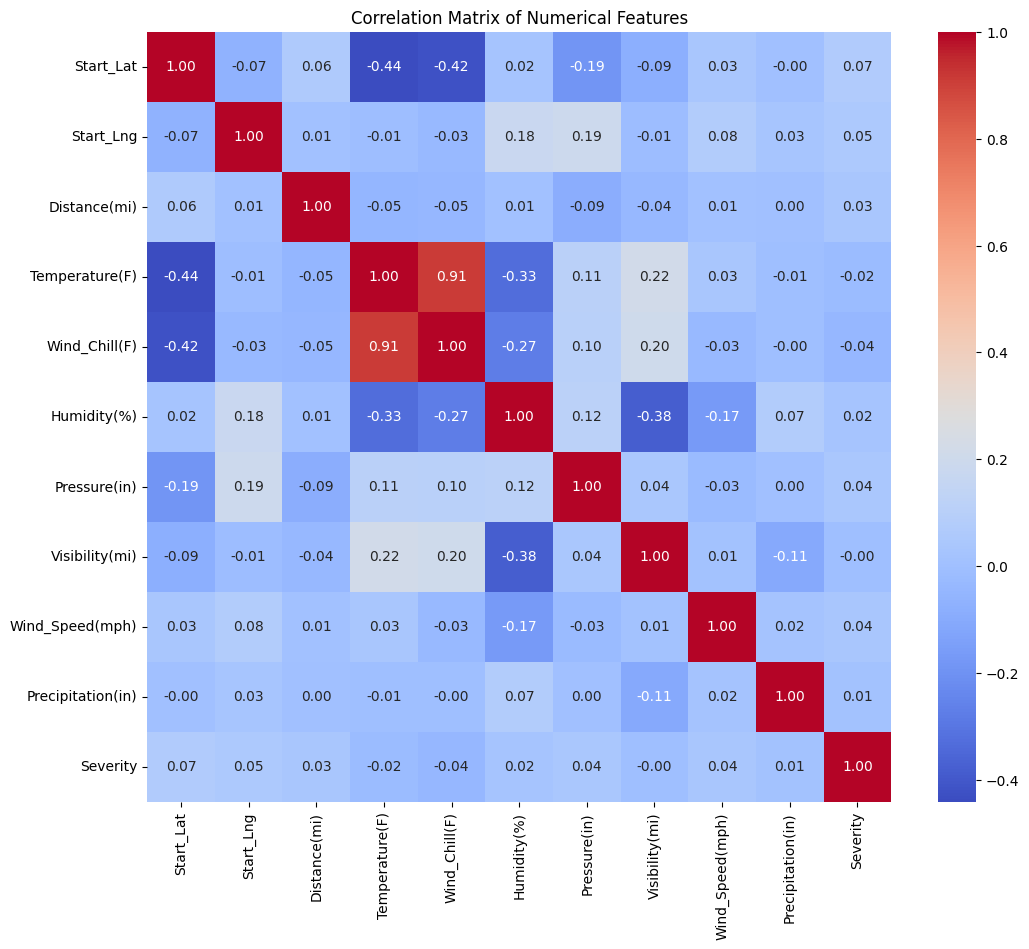

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

numerical_features = [
    'Start_Lat', 'Start_Lng', 'Distance(mi)',
    'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
    'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)',
    'Severity'
]

sample_df = df.select(numerical_features).sample(withReplacement=False, fraction=0.1, seed=42)
pandas_df = sample_df.toPandas()

plt.figure(figsize=(12, 10))
sns.heatmap(pandas_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


On remarque que les colonnes `Wind_Chill(F)` et `Temperature(F)` sont tres correlees entres elles, alors on peut en supprimer une des deux

In [ ]:
df = df.drop("Wind_Chill(F)")

Pour le choix du model final, on va utiliser un subset du dataframe pour eviter des entrainements trop long

In [6]:
df_sample = df.sample(fraction=0.1, seed=42)

On fait un split `80/20`

In [7]:
train_data, test_data = df_sample.randomSplit([0.8, 0.2], seed=42)

## Pipeline

In [18]:
from pyspark.ml.feature import VectorAssembler

feature_cols = columns_to_keep[1:]
feature_cols.remove("Wind_Chill(F)")

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

On choisie 3 modeles different pour notre analyse que voici:
- Random Forest
- GBT
- Logistic Regression

In [19]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier

models = {
    "Random Forest": RandomForestClassifier(labelCol="Severity", featuresCol="features"),
    "Logistic Regression": LogisticRegression(labelCol="Severity", featuresCol="features"),
    "Decision Tree": DecisionTreeClassifier(labelCol="Severity", featuresCol="features")
}

In [24]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedRecall")

In [25]:
from pyspark.ml import Pipeline

def train_and_evaluate(model_name, model):
    print(f"Training model: {model_name}")
    pipeline = Pipeline(stages=[assembler, model])
    pipeline_model = pipeline.fit(train_data)
    predictions = pipeline_model.transform(test_data)
    f1_score = evaluator_f1.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)
    return pipeline_model, f1_score, precision, recall

## Entrainement

In [26]:
results = {}

for model_name, model in models.items():
    trained_model, f1_score, precision, recall = train_and_evaluate(model_name, model)
    results[model_name] = {
        "model": trained_model,
        "f1_score": f1_score,
        "precision": precision,
        "recall": recall
    }

Training model: Random Forest


Training model: Logistic Regression


Training model: Decision Tree


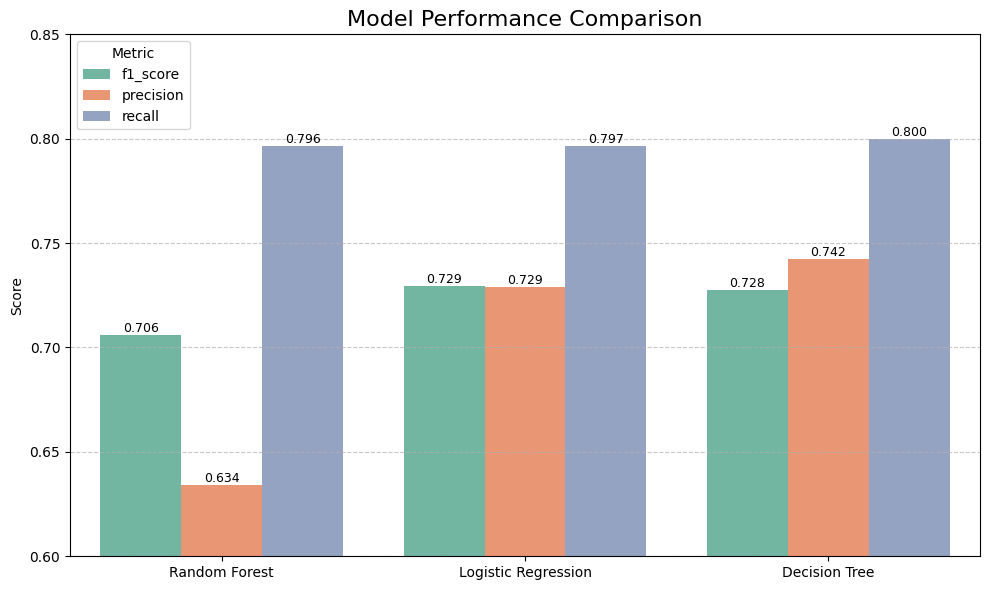

In [ ]:
df_results = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Model"})
df_melted = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")
df_melted = df_melted[df_melted["Metric"] != "model"]
df_melted["Score"] = df_melted["Score"].astype(float)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric", palette="Set2")

for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=9)

plt.title("Model Performance Comparison", fontsize=16)
plt.ylim(0.6, 0.85)
plt.ylabel("Score")
plt.xlabel("")
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
